In [61]:
%matplotlib inline
from torch import optim, nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [383]:
class FeedForwardNet3(nn.Module):
    """ Simple feed forward network with two hidden layers."""
    def __init__(self): # initialize the model
        super(FeedForwardNet3, self).__init__() # call for the parent class to initialize
        self.Nfeatures = 16#27
        self.Noutcomes = 1
        self.Nsamples = 50
        weight1_shape = [self.Nfeatures, self.Nsamples]
        weight2_shape = [self.Nsamples, self.Nsamples]
        weight3_shape = [self.Nsamples, self.Nsamples]
        weight4_shape = [self.Nsamples, self.Noutcomes]


        self.W1 = nn.Linear(*weight1_shape)
        self.W2 = nn.Linear(*weight2_shape)
        self.W3 = nn.Linear(*weight3_shape)
        self.W4 = nn.Linear(*weight4_shape)


    def forward(self, x):
        """
        this is the function that will be executed when we call the logistic regression on data.
        INPUT:
            x, a photometric data vector represented as a tensor of shape 27
        OUTPUT:
            forward_result, a tensor of shape 1
        """
        activation_fn = nn.ReLU()

        forward_result = self.W1(x)
        forward_result = activation_fn(forward_result)

        forward_result = self.W2(forward_result)
        forward_result = activation_fn(forward_result)

        forward_result = self.W3(forward_result)
        forward_result = activation_fn(forward_result)

        forward_result = self.W4(forward_result)

        forward_result = torch.reshape(forward_result, [self.Nsamples, self.Noutcomes])

        return forward_result
    
def nan_to_num(t,mynan=0.):
    if torch.all(torch.isfinite(t)):
        return t
    if len(t.size()) == 0:
        return torch.tensor(mynan)
    return torch.cat([nan_to_num(l).unsqueeze(0) for l in t],0)

def train(model,loss_fn, optimizer, train_loader, test_loader):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    num_epochs = 2000
    print("number of epochs", num_epochs)
    for epoch in range(num_epochs):
        print("epoch", epoch)
        # loop through each data point in the training set
        for data, targets in train_loader:
            # run the model on the data
            Nsample = len(targets)
            Nfeatures = len(data.T)
            model_input = torch.reshape(data, (Nsample, Nfeatures))
            out = model(model_input)
            while torch.isnan(sum(sum(out))) or torch.isinf(sum(sum(out))):
                print("sum(sum(model_input))", sum(sum(model_input)))
                #print("model_input", model_input)
                print("sum(sum(out))", sum(sum(out)))
                print('invalid input detected at iteration ', epoch)
                model_input = nan_to_num(model_input)
                out = model(model_input)
            loss = loss_fn(out, targets)

            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            optimizer.zero_grad()
        print("loss", loss.item())
        # Give status reports every 5 epochs
        if epoch % 5==0:
            evaluate_train = np.round(evaluate(model,train_loader, Nsample=Nsample), 4)
            evaluate_test = np.round(evaluate(model,test_loader, Nsample=Nsample), 4)

            evaluate_test = np.round(evaluate_test, 4)
            dataseries = pd.Series({"epoch":int(epoch),
                                    "Train accuracy": evaluate_train,
                                    "Test accuracy": evaluate_test,
                                    "Loss" : np.round(loss.item(), 4)}
                                   )
            if epoch==0:
                df_accuracy = pd.DataFrame()

            df_accuracy = df_accuracy.append(dataseries, ignore_index=True)
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            print(f" Train accuracy: {evaluate_train}. Test accuracy: {evaluate_test}")
            df_accuracy.to_csv("dataframe_accuracy.csv")





def evaluate(model, evaluation_set, Nsample=25, Nfeatures=16, return_confusion=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    correct = []
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        for data, targets in evaluation_set:
            try:
                model_input = torch.reshape(data, [Nsample, Nfeatures])
            except RuntimeError:
                break
            result = model(model_input)
            for ii, result_line in enumerate(result):
                if abs(result_line-targets[ii])<0.05:
                    correct.append(1)
                else:
                    correct.append(0)
    
    accuracy = np.sum(correct)/np.float(len(correct))
    return accuracy

In [198]:
sdss_photo_data = np.load("photometric_data.npy")
ground_truth_sfrs = np.load("sfr_data_synced_to_photo_dictionary.npy")

In [310]:
photodf = pd.DataFrame(sdss_photo_data, columns=['fiber_g_mag', 'full_g_mag',
                                        'fiber_r_mag', 'full_r_mag',
                                        'fiber_z_mag', 'full_z_mag',
                                        'fiber_nuv_mag', 'full_nuv_mag',
                                        'fiber_fuv_mag', 'full_fuv_mag',
                                        'g_r_fiber', 'g_r_full',
                                        'r_z_fiber', 'r_z_full',
                                        'fuv_nuv_fiber', 'fuv_nuv_full', 
                                        'full_g_mag1', 'full_r_mag1', 'full_z_mag1',
                                        'fiber_g_mag1', 'fiber_r_mag1', 'fiber_z_mag1',
                                        'full_nuv_mag1', 'full_fuv_mag1',
                                        'fiber_nuv_mag1', 'fiber_nuv_mag1','halpha'])


In [311]:
photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,...,full_r_mag1,full_z_mag1,fiber_g_mag1,fiber_r_mag1,fiber_z_mag1,full_nuv_mag1,full_fuv_mag1,fiber_nuv_mag1,fiber_nuv_mag1,halpha
0,20.630505,20.630505,20.072167,20.072167,19.592112,19.592112,22.856167,22.856167,24.027126,24.027126,...,20.072167,19.592112,20.630505,20.072167,19.592112,22.856167,24.027126,22.856167,22.856167,21.083307
1,21.055134,20.527209,20.459412,19.929611,20.145202,19.625306,23.416416,22.795154,24.905366,24.351031,...,19.929611,19.625306,21.055134,20.459412,20.145202,22.795154,24.351031,23.416416,23.416416,38.808548
2,21.417541,20.262839,20.548975,19.422085,19.852283,18.770072,24.532448,23.213055,26.663405,25.484405,...,19.422085,18.770072,21.417541,20.548975,19.852283,23.213055,25.484405,24.532448,24.532448,16.460962
3,20.525722,20.525722,19.407658,19.407658,18.345308,18.345308,25.205080,25.205080,26.671650,26.671650,...,19.407658,18.345308,20.525722,19.407658,18.345308,25.205080,26.671650,25.205080,25.205080,7.550173
4,19.643996,19.643996,18.630520,18.630520,17.745149,17.745149,24.311589,24.311589,26.510112,26.510112,...,18.630520,17.745149,19.643996,18.630520,17.745149,24.311589,26.510112,24.311589,24.311589,45.684097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,19.585434,20.303935,18.745119,19.430541,18.364688,19.065300,22.479885,23.428571,24.218554,25.293604,...,19.430541,19.065300,19.585434,18.745119,18.364688,23.428571,25.293604,22.479885,22.479885,48.699116
1121,19.625556,19.625556,18.571757,18.571757,18.031223,18.031223,24.140795,24.140795,NaN,NaN,...,18.571757,18.031223,19.625556,18.571757,18.031223,24.140795,NaN,24.140795,24.140795,0.964168
1122,18.628855,19.267435,17.626053,18.186219,17.400468,18.054300,NaN,NaN,24.733214,25.430543,...,18.186219,18.054300,18.628855,17.626053,17.400468,NaN,25.430543,NaN,NaN,0.287338
1123,19.995803,20.761115,19.570410,20.359438,18.877564,19.612700,22.256783,23.119402,24.142387,25.038750,...,20.359438,19.612700,19.995803,19.570410,18.877564,23.119402,25.038750,22.256783,22.256783,30.601612


[Text(0.5, 0, 'H-$\\alpha$ equivalent width'),
 Text(0, 0.5, 'log SFR$_{\\mathrm{SED}}$ from GSWLC $[M_\\odot$ yr$^{-1}$]')]

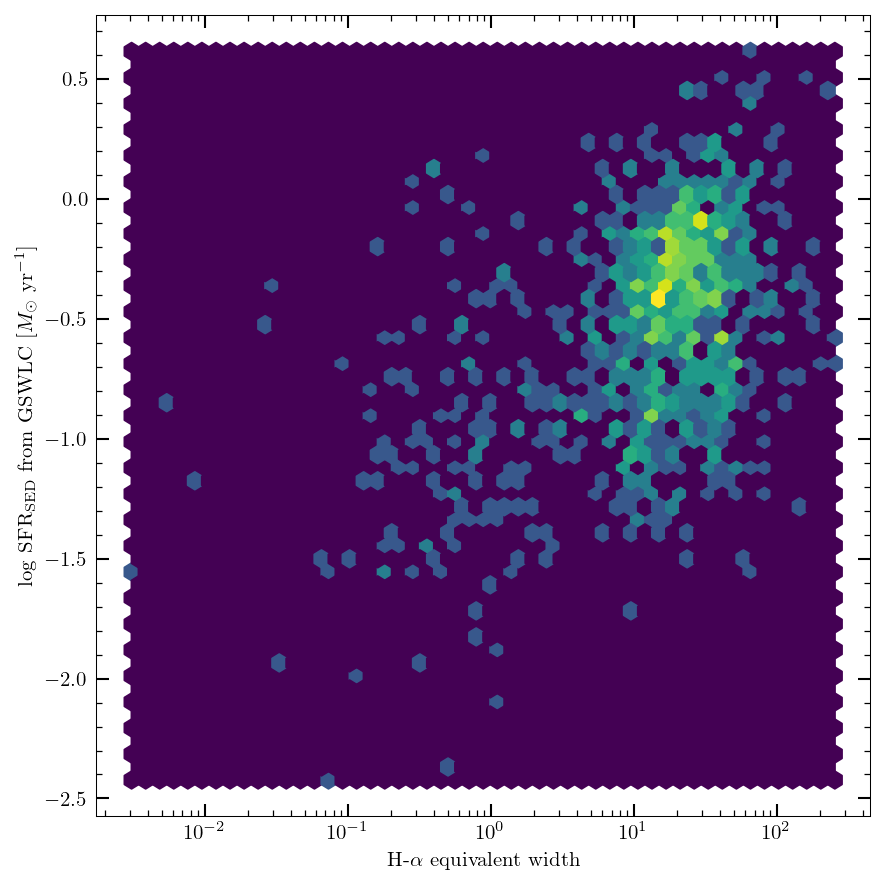

In [52]:
fig, axes = plt.subplots(figsize=(6,6), dpi=150)
axes.hexbin(photodf['halpha'].values, ground_truth_sfrs,bins='log', xscale='log', gridsize=50)
axes.set(xlabel=r"H-$\alpha$ equivalent width",
         ylabel=r'log SFR$_{\mathrm{SED}}$ from GSWLC $[M_\odot$ yr$^{-1}$]')

[Text(0.5, 0, 'H-$\\alpha$ equivalent width'), Text(0, 0.5, 'fiber (g-r)')]

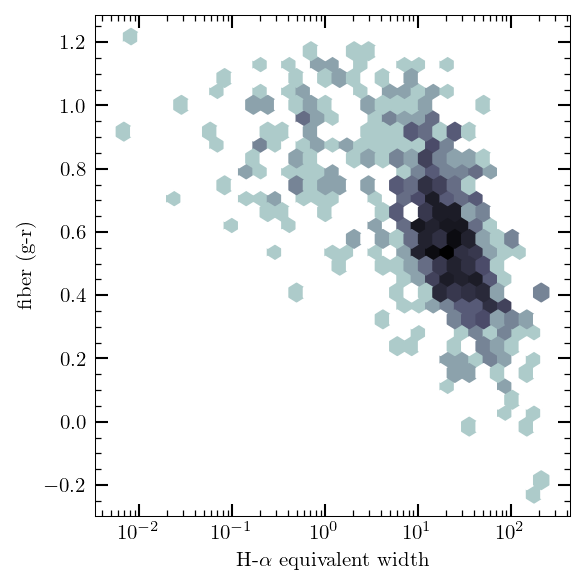

In [36]:
fig, axes = plt.subplots(figsize=(4,4), dpi=150)
axes.hexbin(photodf['halpha'].values, photodf['g_r_fiber'].values, bins='log', xscale='log',
            gridsize=30, cmap='bone_r')
axes.set(xlabel=r"H-$\alpha$ equivalent width",
         ylabel=r'fiber (g-r)')

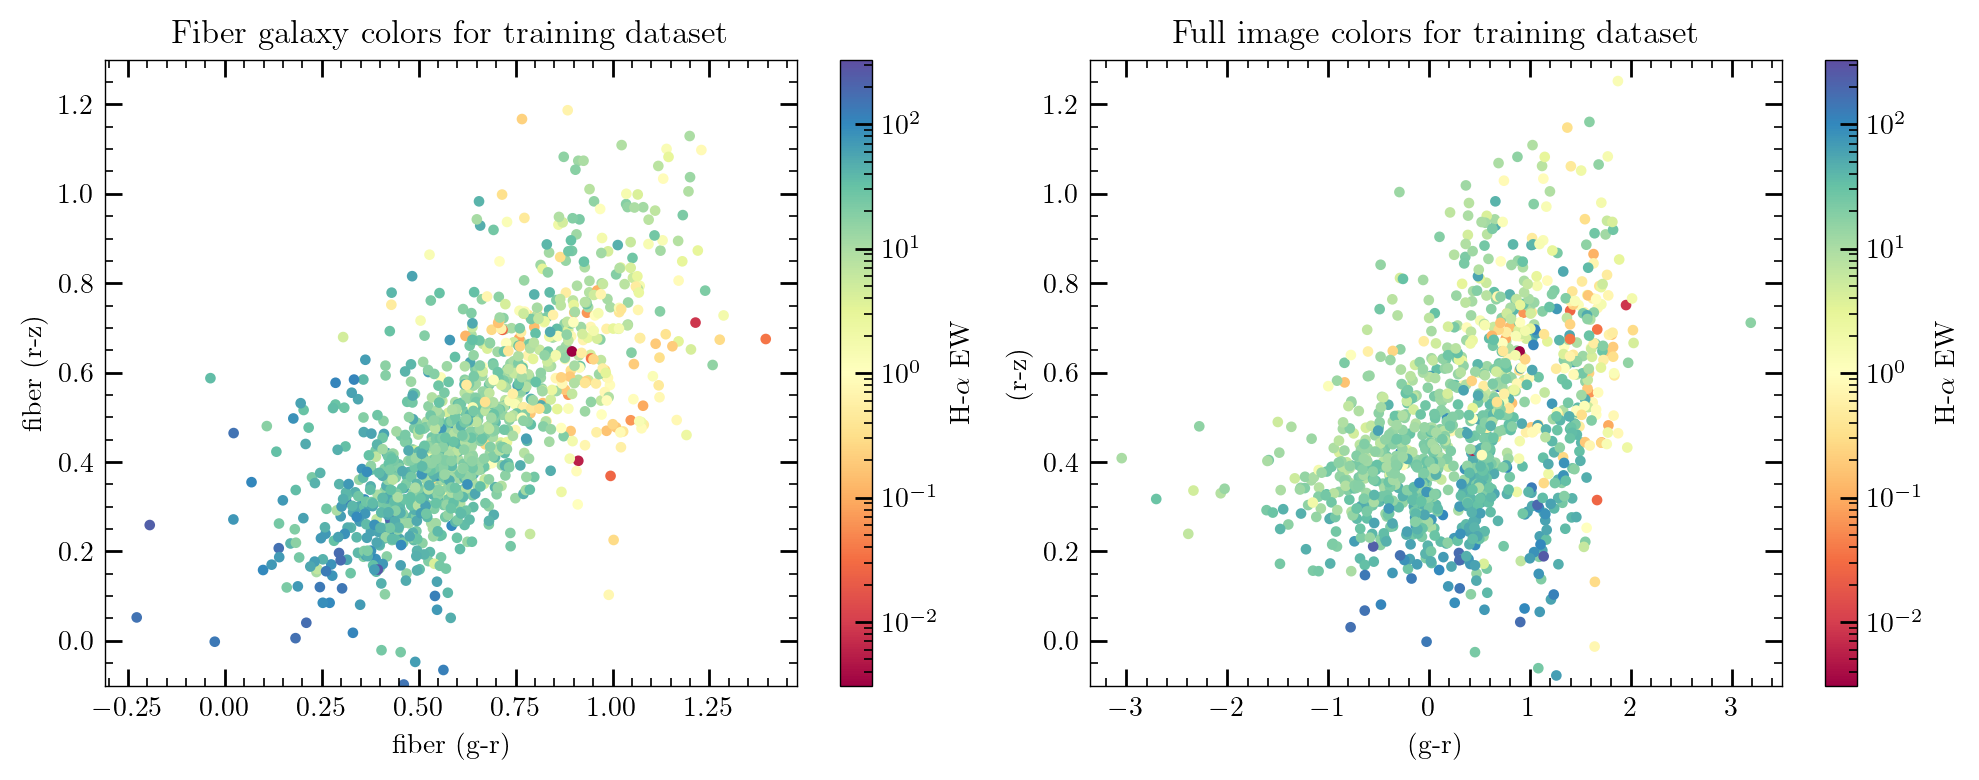

In [68]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(photodf['g_r_fiber'].values, photodf['r_z_fiber'].values, s=8,
                           c=photodf['halpha'].values, norm=LogNorm(), cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="fiber (g-r)", ylabel='fiber (r-z)', title="Fiber galaxy colors for training dataset", ylim=(-0.1, 1.3))
cbar.ax.set_ylabel(r'H-$\alpha$ EW')

fiber_scat = axes[1].scatter(photodf['g_r_full'].values, photodf['r_z_full'].values,
                             c=photodf['halpha'].values, s=8, norm=LogNorm(), cmap='Spectral')
cbar = fig.colorbar(fiber_scat, ax=axes[1])
axes[1].set(xlabel="(g-r)", ylabel='(r-z)', ylim=(-0.1, 1.3))
cbar.ax.set_ylabel(r'H-$\alpha$ EW')
axes[1].set_title("Full image colors for training dataset")
plt.tight_layout()

In [345]:
data_length = len(sdss_photo_data)
train_cap = int(np.floor(0.75*data_length / 50)*50)
print(train_cap)
device = torch.device("cpu")
train_input = torch.Tensor(photo_data_array[:train_cap])
train_ground_truth = torch.Tensor(cleaned_SFR[:train_cap], device=device)
test_input = torch.Tensor(photo_data_array[train_cap:])
test_ground_truth = torch.Tensor(cleaned_SFR[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

number of epochs 2000
epoch 0
loss 0.2854233384132385
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.0988. Test accuracy: 0.115
epoch 1
loss 0.28817176818847656
epoch 2
loss 0.28799837827682495
epoch 3
loss 0.2878513038158417
epoch 4
loss 0.28785234689712524
epoch 5


/opt/anaconda3/envs/py3/lib/python3.7/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss 0.2879112660884857
 EPOCH 5. Progress: 0.25%. 
 Train accuracy: 0.0838. Test accuracy: 0.075
epoch 6
loss 0.28798943758010864
epoch 7
loss 0.28807133436203003
epoch 8
loss 0.2881503403186798
epoch 9
loss 0.28822335600852966
epoch 10
loss 0.2882891297340393
 EPOCH 10. Progress: 0.5%. 
 Train accuracy: 0.0825. Test accuracy: 0.075
epoch 11
loss 0.28834718465805054
epoch 12
loss 0.28839775919914246
epoch 13
loss 0.2884412705898285
epoch 14
loss 0.28847840428352356
epoch 15
loss 0.2885098457336426
 EPOCH 15. Progress: 0.75%. 
 Train accuracy: 0.0825. Test accuracy: 0.08
epoch 16
loss 0.2885363698005676
epoch 17
loss 0.28855863213539124
epoch 18
loss 0.28857725858688354
epoch 19
loss 0.2885928750038147
epoch 20
loss 0.2886058986186981
 EPOCH 20. Progress: 1.0%. 
 Train accuracy: 0.08. Test accuracy: 0.08
epoch 21
loss 0.2886168360710144
epoch 22
loss 0.2886260151863098
epoch 23
loss 0.28863370418548584
epoch 24
loss 0.28864017128944397
epoch 25
loss 0.2886456847190857
 EPOCH 25. Progre

loss 0.2886962294578552
epoch 177
loss 0.28869643807411194
epoch 178
loss 0.28869667649269104
epoch 179
loss 0.2886969745159149
epoch 180
loss 0.288697212934494
 EPOCH 180. Progress: 9.0%. 
 Train accuracy: 0.0812. Test accuracy: 0.08
epoch 181
loss 0.28869742155075073
epoch 182
loss 0.28869765996932983
epoch 183
loss 0.28869789838790894
epoch 184
loss 0.28869813680648804
epoch 185
loss 0.28869837522506714
 EPOCH 185. Progress: 9.25%. 
 Train accuracy: 0.0812. Test accuracy: 0.08
epoch 186
loss 0.28869861364364624
epoch 187
loss 0.28869888186454773
epoch 188
loss 0.28869906067848206
epoch 189
loss 0.28869932889938354
epoch 190
loss 0.28869950771331787
 EPOCH 190. Progress: 9.5%. 
 Train accuracy: 0.0812. Test accuracy: 0.08
epoch 191
loss 0.288699746131897
epoch 192
loss 0.28870001435279846
epoch 193
loss 0.2887002229690552
epoch 194
loss 0.2887004315853119
epoch 195
loss 0.288700670003891
 EPOCH 195. Progress: 9.75%. 
 Train accuracy: 0.0812. Test accuracy: 0.08
epoch 196
loss 0.28870

loss 0.2887214720249176
epoch 344
loss 0.28872159123420715
epoch 345
loss 0.2887216806411743
 EPOCH 345. Progress: 17.25%. 
 Train accuracy: 0.0812. Test accuracy: 0.08
epoch 346
loss 0.28872179985046387
epoch 347
loss 0.28872188925743103
epoch 348
loss 0.2887220084667206
epoch 349
loss 0.28872212767601013
epoch 350
loss 0.2887222468852997
 EPOCH 350. Progress: 17.5%. 
 Train accuracy: 0.0812. Test accuracy: 0.08
epoch 351
loss 0.28872230648994446
epoch 352
loss 0.288722425699234
epoch 353
loss 0.28872251510620117
epoch 354
loss 0.28872260451316833
epoch 355
loss 0.2887227535247803
 EPOCH 355. Progress: 17.75%. 
 Train accuracy: 0.0812. Test accuracy: 0.08
epoch 356
loss 0.28872281312942505
epoch 357
loss 0.288722962141037
epoch 358
loss 0.28872302174568176
epoch 359
loss 0.2887231707572937
epoch 360
loss 0.28872326016426086
 EPOCH 360. Progress: 18.0%. 
 Train accuracy: 0.0812. Test accuracy: 0.08
epoch 361
loss 0.288723349571228
epoch 362
loss 0.28872349858283997
epoch 363
loss 0.288

 EPOCH 510. Progress: 25.5%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 511
loss 0.2887464463710785
epoch 512
loss 0.2887466251850128
epoch 513
loss 0.2887468636035919
epoch 514
loss 0.28874707221984863
epoch 515
loss 0.28874725103378296
 EPOCH 515. Progress: 25.75%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 516
loss 0.2887474298477173
epoch 517
loss 0.2887476682662964
epoch 518
loss 0.2887478768825531
epoch 519
loss 0.2887480854988098
epoch 520
loss 0.28874829411506653
 EPOCH 520. Progress: 26.0%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 521
loss 0.28874847292900085
epoch 522
loss 0.28874868154525757
epoch 523
loss 0.2887488901615143
epoch 524
loss 0.288749098777771
epoch 525
loss 0.2887492775917053
 EPOCH 525. Progress: 26.25%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 526
loss 0.28874945640563965
epoch 527
loss 0.28874969482421875
epoch 528
loss 0.2887498736381531
epoch 529
loss 0.2887501120567322
epoch 530
loss 0.2887502908706665
 EPOCH 530. 

loss 0.2887818217277527
epoch 679
loss 0.2887820303440094
epoch 680
loss 0.2887822091579437
 EPOCH 680. Progress: 34.0%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 681
loss 0.28878238797187805
epoch 682
loss 0.28878262639045715
epoch 683
loss 0.2887828052043915
epoch 684
loss 0.2887830436229706
epoch 685
loss 0.2887831926345825
 EPOCH 685. Progress: 34.25%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 686
loss 0.288783460855484
epoch 687
loss 0.28878363966941833
epoch 688
loss 0.28878384828567505
epoch 689
loss 0.2887840270996094
epoch 690
loss 0.2887842655181885
 EPOCH 690. Progress: 34.5%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 691
loss 0.2887844741344452
epoch 692
loss 0.2887846529483795
epoch 693
loss 0.28878486156463623
epoch 694
loss 0.28878507018089294
epoch 695
loss 0.28878524899482727
 EPOCH 695. Progress: 34.75%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 696
loss 0.28878548741340637
epoch 697
loss 0.2887856662273407
epoch 698
loss 0.2887

loss 0.28881368041038513
 EPOCH 850. Progress: 42.5%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 851
loss 0.28881382942199707
epoch 852
loss 0.288813978433609
epoch 853
loss 0.28881415724754333
epoch 854
loss 0.28881433606147766
epoch 855
loss 0.2888144850730896
 EPOCH 855. Progress: 42.75%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 856
loss 0.28881463408470154
epoch 857
loss 0.28881481289863586
epoch 858
loss 0.2888149321079254
epoch 859
loss 0.28881514072418213
epoch 860
loss 0.28881528973579407
 EPOCH 860. Progress: 43.0%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 861
loss 0.2888154685497284
epoch 862
loss 0.28881561756134033
epoch 863
loss 0.28881576657295227
epoch 864
loss 0.2888159453868866
epoch 865
loss 0.2888161242008209
 EPOCH 865. Progress: 43.25%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 866
loss 0.28881627321243286
epoch 867
loss 0.2888164520263672
epoch 868
loss 0.28881657123565674
epoch 869
loss 0.2888167202472687
epoch 870
loss 0.

loss 0.28883853554725647
epoch 1019
loss 0.2888386845588684
epoch 1020
loss 0.28883877396583557
 EPOCH 1020. Progress: 51.0%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 1021
loss 0.2888389229774475
epoch 1022
loss 0.28883904218673706
epoch 1023
loss 0.288839191198349
epoch 1024
loss 0.28883931040763855
epoch 1025
loss 0.2888393998146057
 EPOCH 1025. Progress: 51.24999999999999%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 1026
loss 0.28883954882621765
epoch 1027
loss 0.288839727640152
epoch 1028
loss 0.28883981704711914
epoch 1029
loss 0.2888399660587311
epoch 1030
loss 0.28884008526802063
 EPOCH 1030. Progress: 51.5%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 1031
loss 0.28884023427963257
epoch 1032
loss 0.28884032368659973
epoch 1033
loss 0.28884050250053406
epoch 1034
loss 0.2888405919075012
epoch 1035
loss 0.28884074091911316
 EPOCH 1035. Progress: 51.74999999999999%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 1036
loss 0.2888408601284027
epoch 1

loss 0.2888576090335846
epoch 1178
loss 0.28885772824287415
epoch 1179
loss 0.2888578474521637
epoch 1180
loss 0.28885796666145325
 EPOCH 1180. Progress: 59.0%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 1181
loss 0.2888580858707428
epoch 1182
loss 0.28885817527770996
epoch 1183
loss 0.2888582646846771
epoch 1184
loss 0.28885841369628906
epoch 1185
loss 0.2888585031032562
 EPOCH 1185. Progress: 59.25%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 1186
loss 0.28885865211486816
epoch 1187
loss 0.28885871171951294
epoch 1188
loss 0.2888588309288025
epoch 1189
loss 0.28885895013809204
epoch 1190
loss 0.2888590395450592
 EPOCH 1190. Progress: 59.5%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 1191
loss 0.28885912895202637
epoch 1192
loss 0.2888592481613159
epoch 1193
loss 0.28885936737060547
epoch 1194
loss 0.288859486579895
epoch 1195
loss 0.28885960578918457
 EPOCH 1195. Progress: 59.75%. 
 Train accuracy: 0.0812. Test accuracy: 0.07
epoch 1196
loss 0.2888596653938

loss 0.2888737916946411
 EPOCH 1340. Progress: 67.0%. 
 Train accuracy: 0.0825. Test accuracy: 0.07
epoch 1341
loss 0.2888738811016083
epoch 1342
loss 0.2888740003108978
epoch 1343
loss 0.2888740599155426
epoch 1344
loss 0.28887420892715454
epoch 1345
loss 0.2888742685317993
 EPOCH 1345. Progress: 67.25%. 
 Train accuracy: 0.0825. Test accuracy: 0.07
epoch 1346
loss 0.2888743281364441
epoch 1347
loss 0.28887441754341125
epoch 1348
loss 0.2888745665550232
epoch 1349
loss 0.2888745963573456
epoch 1350
loss 0.2888747453689575
 EPOCH 1350. Progress: 67.5%. 
 Train accuracy: 0.0825. Test accuracy: 0.07
epoch 1351
loss 0.2888748049736023
epoch 1352
loss 0.28887492418289185
epoch 1353
loss 0.288875013589859
epoch 1354
loss 0.28887510299682617
epoch 1355
loss 0.28887516260147095
 EPOCH 1355. Progress: 67.75%. 
 Train accuracy: 0.0825. Test accuracy: 0.07
epoch 1356
loss 0.2888752520084381
epoch 1357
loss 0.2888753414154053
epoch 1358
loss 0.2888754606246948
epoch 1359
loss 0.288875550031662
ep

 EPOCH 1505. Progress: 75.25%. 
 Train accuracy: 0.0825. Test accuracy: 0.075
epoch 1506
loss 0.28888756036758423
epoch 1507
loss 0.2888876497745514
epoch 1508
loss 0.28888770937919617
epoch 1509
loss 0.28888779878616333
epoch 1510
loss 0.2888878285884857
 EPOCH 1510. Progress: 75.5%. 
 Train accuracy: 0.0825. Test accuracy: 0.075
epoch 1511
loss 0.28888794779777527
epoch 1512
loss 0.28888803720474243
epoch 1513
loss 0.2888880670070648
epoch 1514
loss 0.28888818621635437
epoch 1515
loss 0.28888824582099915
 EPOCH 1515. Progress: 75.75%. 
 Train accuracy: 0.0825. Test accuracy: 0.075
epoch 1516
loss 0.2888883054256439
epoch 1517
loss 0.2888883650302887
epoch 1518
loss 0.28888842463493347
epoch 1519
loss 0.28888851404190063
epoch 1520
loss 0.2888886034488678
 EPOCH 1520. Progress: 76.0%. 
 Train accuracy: 0.0825. Test accuracy: 0.075
epoch 1521
loss 0.2888886630535126
epoch 1522
loss 0.28888872265815735
epoch 1523
loss 0.2888888120651245
epoch 1524
loss 0.2888889014720917
epoch 1525
loss

loss 0.28889894485473633
 EPOCH 1670. Progress: 83.5%. 
 Train accuracy: 0.0812. Test accuracy: 0.075
epoch 1671
loss 0.2888989746570587
epoch 1672
loss 0.2888990640640259
epoch 1673
loss 0.28889912366867065
epoch 1674
loss 0.28889918327331543
epoch 1675
loss 0.2888992428779602
 EPOCH 1675. Progress: 83.75%. 
 Train accuracy: 0.0812. Test accuracy: 0.075
epoch 1676
loss 0.28889936208724976
epoch 1677
loss 0.28889939188957214
epoch 1678
loss 0.2888994514942169
epoch 1679
loss 0.2888995110988617
epoch 1680
loss 0.28889957070350647
 EPOCH 1680. Progress: 84.0%. 
 Train accuracy: 0.0812. Test accuracy: 0.075
epoch 1681
loss 0.28889966011047363
epoch 1682
loss 0.288899689912796
epoch 1683
loss 0.2888997495174408
epoch 1684
loss 0.28889983892440796
epoch 1685
loss 0.28889983892440796
 EPOCH 1685. Progress: 84.25%. 
 Train accuracy: 0.0812. Test accuracy: 0.075
epoch 1686
loss 0.2888999581336975
epoch 1687
loss 0.2888999879360199
epoch 1688
loss 0.2889000475406647
epoch 1689
loss 0.2889001369

loss 0.28890883922576904
epoch 1838
loss 0.2889088988304138
epoch 1839
loss 0.2889089584350586
epoch 1840
loss 0.288908988237381
 EPOCH 1840. Progress: 92.0%. 
 Train accuracy: 0.0812. Test accuracy: 0.075
epoch 1841
loss 0.28890904784202576
epoch 1842
loss 0.2889091372489929
epoch 1843
loss 0.2889091670513153
epoch 1844
loss 0.2889092266559601
epoch 1845
loss 0.28890925645828247
 EPOCH 1845. Progress: 92.25%. 
 Train accuracy: 0.0812. Test accuracy: 0.075
epoch 1846
loss 0.28890931606292725
epoch 1847
loss 0.288909375667572
epoch 1848
loss 0.2889094352722168
epoch 1849
loss 0.2889094948768616
epoch 1850
loss 0.28890952467918396
 EPOCH 1850. Progress: 92.5%. 
 Train accuracy: 0.0812. Test accuracy: 0.075
epoch 1851
loss 0.2889096140861511
epoch 1852
loss 0.2889096140861511
epoch 1853
loss 0.2889097034931183
epoch 1854
loss 0.2889097332954407
epoch 1855
loss 0.28890979290008545
 EPOCH 1855. Progress: 92.75%. 
 Train accuracy: 0.0812. Test accuracy: 0.075
epoch 1856
loss 0.28890985250473

loss 0.2889171242713928


In [337]:
photodf = pd.DataFrame(sdss_photo_data, 
                       columns=['fiber_g_mag', 'full_g_mag',
                                'fiber_r_mag', 'full_r_mag',
                                'fiber_z_mag', 'full_z_mag',
                                'fiber_nuv_mag', 'full_nuv_mag',
                                'fiber_fuv_mag', 'full_fuv_mag',
                                'g_r_fiber', 'g_r_full',
                                'r_z_fiber', 'r_z_full',
                                'fuv_nuv_fiber', 'fuv_nuv_full', 
                                'full_g_mag1', 'full_r_mag1', 'full_z_mag1',
                                'fiber_g_mag1', 'fiber_r_mag1', 'fiber_z_ma1g',
                                'full_nuv_mag1', 'full_fuv_mag1',
                                'fiber_nuv_mag1', 'fiber_nuv_mag1','halpha'])
photodf['SFR'] = ground_truth_sfrs

In [338]:
photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,...,full_z_mag1,fiber_g_mag1,fiber_r_mag1,fiber_z_ma1g,full_nuv_mag1,full_fuv_mag1,fiber_nuv_mag1,fiber_nuv_mag1,halpha,SFR
0,20.630505,20.630505,20.072167,20.072167,19.592112,19.592112,22.856167,22.856167,24.027126,24.027126,...,19.592112,20.630505,20.072167,19.592112,22.856167,24.027126,22.856167,22.856167,21.083307,-0.205
1,21.055134,20.527209,20.459412,19.929611,20.145202,19.625306,23.416416,22.795154,24.905366,24.351031,...,19.625306,21.055134,20.459412,20.145202,22.795154,24.351031,23.416416,23.416416,38.808548,-1.084
2,21.417541,20.262839,20.548975,19.422085,19.852283,18.770072,24.532448,23.213055,26.663405,25.484405,...,18.770072,21.417541,20.548975,19.852283,23.213055,25.484405,24.532448,24.532448,16.460962,-0.257
3,20.525722,20.525722,19.407658,19.407658,18.345308,18.345308,25.205080,25.205080,26.671650,26.671650,...,18.345308,20.525722,19.407658,18.345308,25.205080,26.671650,25.205080,25.205080,7.550173,-1.260
4,19.643996,19.643996,18.630520,18.630520,17.745149,17.745149,24.311589,24.311589,26.510112,26.510112,...,17.745149,19.643996,18.630520,17.745149,24.311589,26.510112,24.311589,24.311589,45.684097,0.028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,19.585434,20.303935,18.745119,19.430541,18.364688,19.065300,22.479885,23.428571,24.218554,25.293604,...,19.065300,19.585434,18.745119,18.364688,23.428571,25.293604,22.479885,22.479885,48.699116,-0.166
1121,19.625556,19.625556,18.571757,18.571757,18.031223,18.031223,24.140795,24.140795,NaN,NaN,...,18.031223,19.625556,18.571757,18.031223,24.140795,NaN,24.140795,24.140795,0.964168,-0.737
1122,18.628855,19.267435,17.626053,18.186219,17.400468,18.054300,NaN,NaN,24.733214,25.430543,...,18.054300,18.628855,17.626053,17.400468,NaN,25.430543,NaN,NaN,0.287338,-0.896
1123,19.995803,20.761115,19.570410,20.359438,18.877564,19.612700,22.256783,23.119402,24.142387,25.038750,...,19.612700,19.995803,19.570410,18.877564,23.119402,25.038750,22.256783,22.256783,30.601612,-0.145


In [339]:
cleaned_photodf = photodf.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
cleaned_photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,...,full_z_mag1,fiber_g_mag1,fiber_r_mag1,fiber_z_ma1g,full_nuv_mag1,full_fuv_mag1,fiber_nuv_mag1,fiber_nuv_mag1,halpha,SFR
0,20.630505,20.630505,20.072167,20.072167,19.592112,19.592112,22.856167,22.856167,24.027126,24.027126,...,19.592112,20.630505,20.072167,19.592112,22.856167,24.027126,22.856167,22.856167,21.083307,-0.205
1,21.055134,20.527209,20.459412,19.929611,20.145202,19.625306,23.416416,22.795154,24.905366,24.351031,...,19.625306,21.055134,20.459412,20.145202,22.795154,24.351031,23.416416,23.416416,38.808548,-1.084
2,21.417541,20.262839,20.548975,19.422085,19.852283,18.770072,24.532448,23.213055,26.663405,25.484405,...,18.770072,21.417541,20.548975,19.852283,23.213055,25.484405,24.532448,24.532448,16.460962,-0.257
3,20.525722,20.525722,19.407658,19.407658,18.345308,18.345308,25.205080,25.205080,26.671650,26.671650,...,18.345308,20.525722,19.407658,18.345308,25.205080,26.671650,25.205080,25.205080,7.550173,-1.260
4,19.643996,19.643996,18.630520,18.630520,17.745149,17.745149,24.311589,24.311589,26.510112,26.510112,...,17.745149,19.643996,18.630520,17.745149,24.311589,26.510112,24.311589,24.311589,45.684097,0.028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,19.494771,20.143997,18.584526,19.196629,18.279364,18.943895,23.595577,24.572537,27.751659,29.166077,...,18.943895,19.494771,18.584526,18.279364,24.572537,29.166077,23.595577,23.595577,1.054364,-0.589
1119,19.347455,20.024277,18.943415,19.620984,18.964414,19.682285,22.034316,23.032717,23.471794,24.335829,...,19.682285,19.347455,18.943415,18.964414,23.032717,24.335829,22.034316,22.034316,24.778261,0.032
1120,19.585434,20.303935,18.745119,19.430541,18.364688,19.065300,22.479885,23.428571,24.218554,25.293604,...,19.065300,19.585434,18.745119,18.364688,23.428571,25.293604,22.479885,22.479885,48.699116,-0.166
1123,19.995803,20.761115,19.570410,20.359438,18.877564,19.612700,22.256783,23.119402,24.142387,25.038750,...,19.612700,19.995803,19.570410,18.877564,23.119402,25.038750,22.256783,22.256783,30.601612,-0.145


In [340]:
cleaned_SFR = cleaned_photodf['SFR'].values

In [341]:
cleaned_photodf = cleaned_photodf.drop(columns=['full_g_mag1', 'full_r_mag1', 'full_z_mag1',
                                'fiber_g_mag1', 'fiber_r_mag1', 'fiber_z_ma1g',
                                'full_nuv_mag1', 'full_fuv_mag1',
                                'fiber_nuv_mag1', 'fiber_nuv_mag1', 'SFR'])

In [342]:
cleaned_photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,halpha
0,20.630505,20.630505,20.072167,20.072167,19.592112,19.592112,22.856167,22.856167,24.027126,24.027126,0.558338,0.558338,0.480055,0.480055,1.170959,1.170959,21.083307
1,21.055134,20.527209,20.459412,19.929611,20.145202,19.625306,23.416416,22.795154,24.905366,24.351031,0.595722,0.067797,0.314210,0.304305,1.488950,1.555877,38.808548
2,21.417541,20.262839,20.548975,19.422085,19.852283,18.770072,24.532448,23.213055,26.663405,25.484405,0.868565,-0.286136,0.696693,0.652013,2.130957,2.271350,16.460962
3,20.525722,20.525722,19.407658,19.407658,18.345308,18.345308,25.205080,25.205080,26.671650,26.671650,1.118064,1.118064,1.062350,1.062350,1.466570,1.466570,7.550173
4,19.643996,19.643996,18.630520,18.630520,17.745149,17.745149,24.311589,24.311589,26.510112,26.510112,1.013476,1.013476,0.885371,0.885371,2.198523,2.198523,45.684097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,19.494771,20.143997,18.584526,19.196629,18.279364,18.943895,23.595577,24.572537,27.751659,29.166077,0.910244,1.559470,0.305162,0.252734,4.156081,4.593539,1.054364
1119,19.347455,20.024277,18.943415,19.620984,18.964414,19.682285,22.034316,23.032717,23.471794,24.335829,0.404040,1.080862,-0.020999,-0.061301,1.437478,1.303112,24.778261
1120,19.585434,20.303935,18.745119,19.430541,18.364688,19.065300,22.479885,23.428571,24.218554,25.293604,0.840316,1.558817,0.380431,0.365242,1.738669,1.865033,48.699116
1123,19.995803,20.761115,19.570410,20.359438,18.877564,19.612700,22.256783,23.119402,24.142387,25.038750,0.425393,1.190705,0.692846,0.746738,1.885603,1.919349,30.601612


In [250]:
photo_data_array = cleaned_photodf.values

In [251]:
photo_data_array[:,:-1].shape

(1031, 27)

In [252]:
photo_data_array = photo_data_array[:,:-1]

In [272]:
output_almanach = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in test_loader:
        #print(data)
        #print(data.shape)
        try:
            model_input = torch.reshape(data, [batch_size, 27])
        except RuntimeError as e:
            continue
        output = model(model_input)
        print(output.detach().numpy())
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])

[[-0.47774267]
 [-0.5686556 ]
 [-0.47874653]
 [-0.50907195]
 [-0.5114151 ]
 [-0.4766642 ]
 [-0.5062002 ]
 [-0.5493299 ]
 [-0.4921552 ]
 [-0.4394909 ]
 [-0.5272516 ]
 [-0.41931713]
 [-0.48208296]
 [-0.4797951 ]
 [-0.57371175]
 [-0.45295703]
 [-0.53479075]
 [-0.54076374]
 [-0.5529486 ]
 [-0.56150615]
 [-0.4863783 ]
 [-0.49949944]
 [-0.35099304]
 [-0.44991827]
 [-0.4967636 ]
 [-0.7184645 ]
 [-0.3950752 ]
 [-0.4690405 ]
 [-0.425622  ]
 [-0.52659035]
 [-0.6100693 ]
 [-0.46294224]
 [-0.36812615]
 [-0.59530234]
 [-0.536412  ]
 [-0.4773985 ]
 [-0.51755536]
 [-0.6360117 ]
 [-0.41126645]
 [-0.39342272]
 [-0.60678375]
 [-0.53706276]
 [-0.48370326]
 [-0.52066743]
 [-0.5744469 ]
 [-0.5512208 ]
 [-0.4389633 ]
 [-0.53199565]
 [-0.47741735]
 [-0.55656564]]
[[-0.49505365]
 [-0.5933534 ]
 [-0.5936321 ]
 [-0.5342672 ]
 [-0.60954416]
 [-0.4292835 ]
 [-0.49496305]
 [-0.5759138 ]
 [-0.45206034]
 [-0.47341597]
 [-0.43593276]
 [-0.38299906]
 [-0.50921667]
 [-0.43170512]
 [-0.4920956 ]
 [-0.570598  ]
 [-0.5589

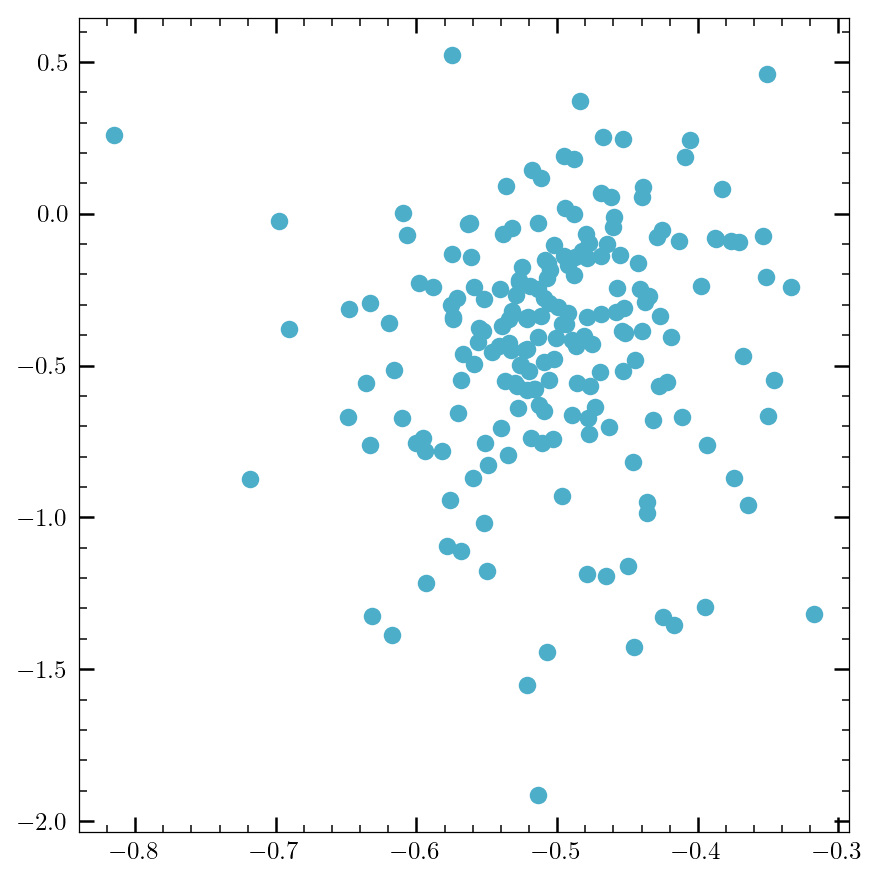

In [274]:
fig, axes = plt.subplots(figsize=(5,5), dpi=180)
axes.scatter(output_almanach, cleaned_SFR[800:1000])

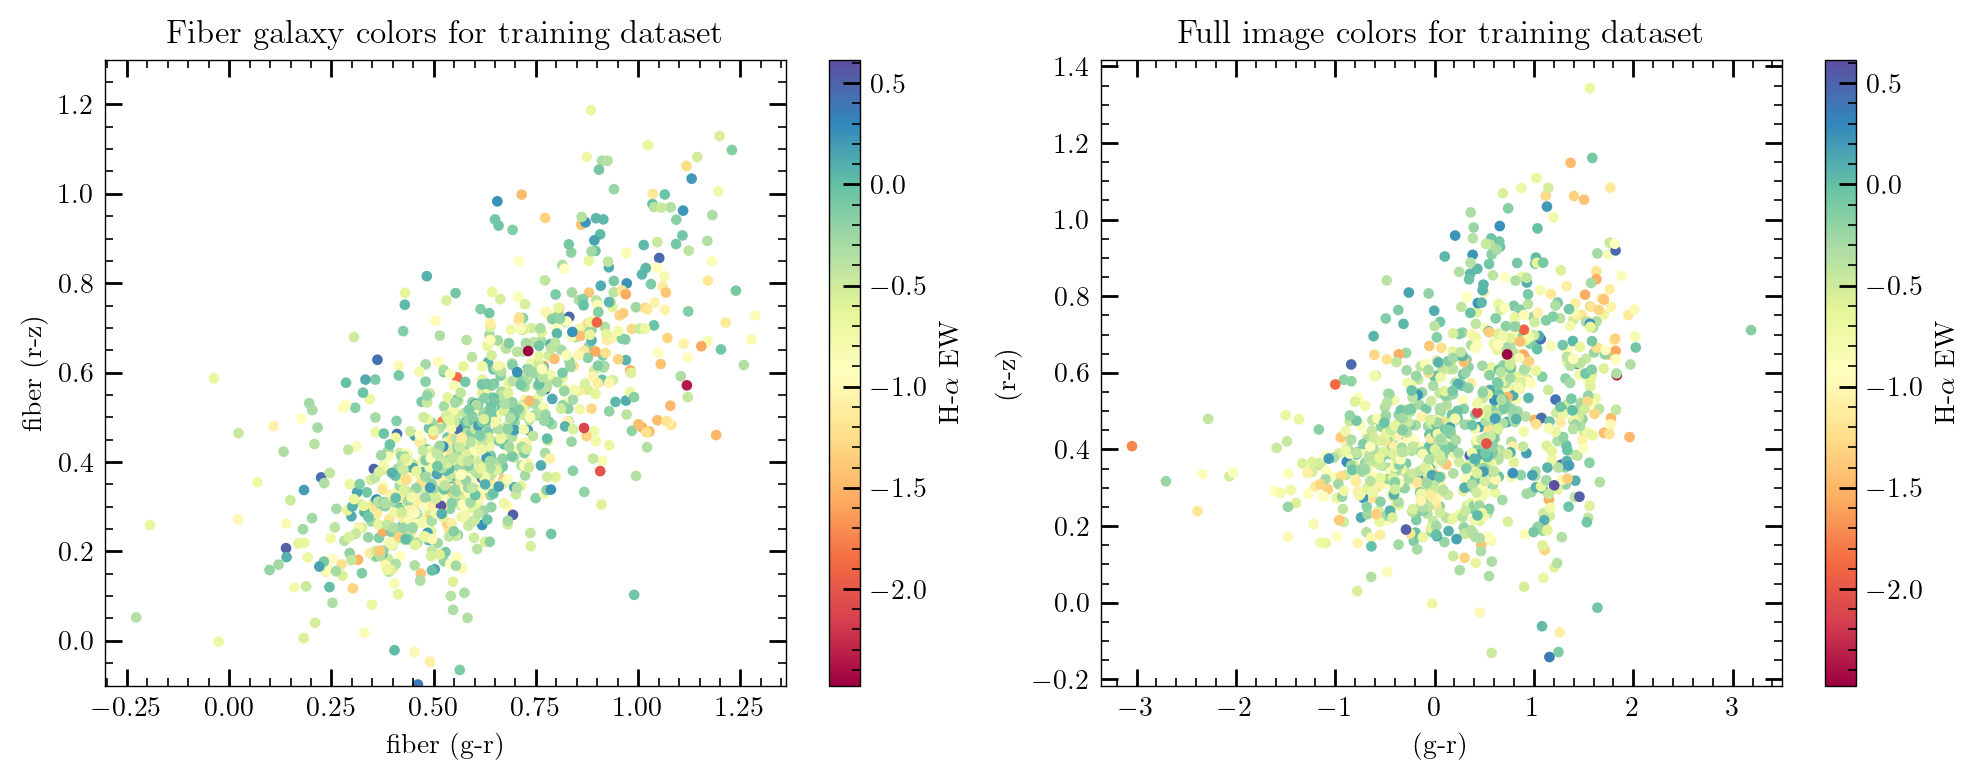

In [291]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(cleaned_photodf['g_r_fiber'].values, cleaned_photodf['r_z_fiber'].values, s=8,
                           c=cleaned_photodf['SFR'].values, #norm=LogNorm(), 
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="fiber (g-r)", ylabel='fiber (r-z)', title="Fiber galaxy colors for training dataset", ylim=(-0.1, 1.3))
cbar.ax.set_ylabel(r'H-$\alpha$ EW')

fiber_scat = axes[1].scatter(cleaned_photodf['g_r_full'].values, cleaned_photodf['r_z_full'].values,s=8,
                             c=cleaned_photodf['SFR'].values,   cmap='Spectral'
                            )
cbar = fig.colorbar(fiber_scat, ax=axes[1])
axes[1].set(xlabel="(g-r)", ylabel='(r-z)')#, ylim=(-0.1, 1.3))
cbar.ax.set_ylabel(r'H-$\alpha$ EW')
axes[1].set_title("Full image colors for training dataset")
plt.tight_layout()

In [289]:
len(np.unique(cleaned_photodf['SFR'].values))

738

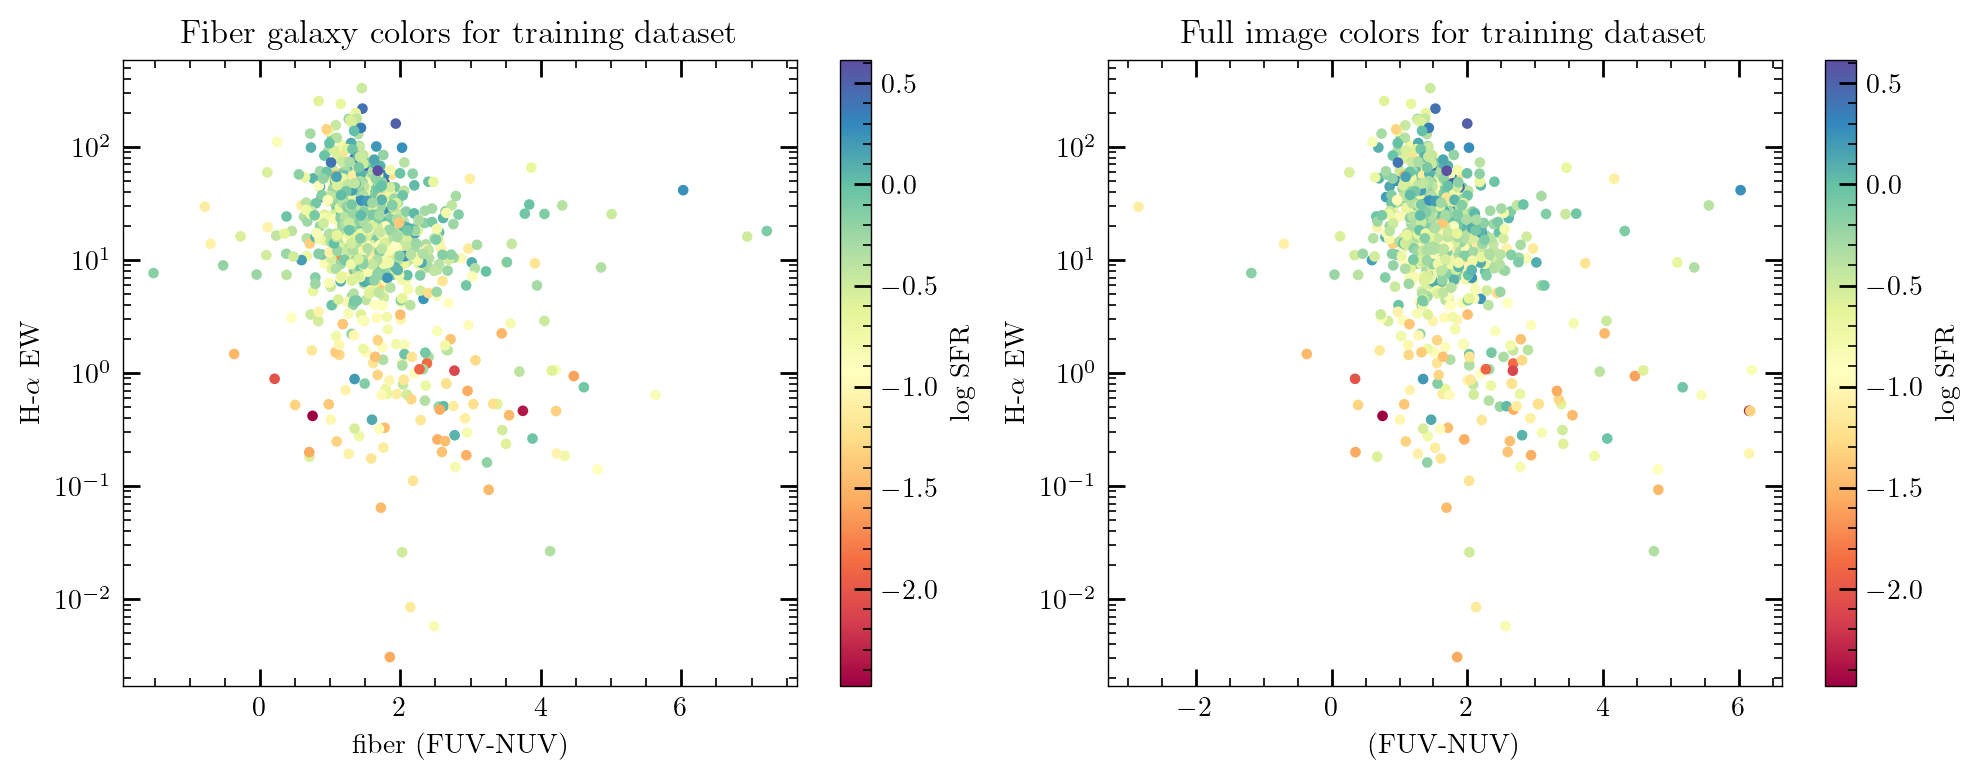

In [296]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(cleaned_photodf['fuv_nuv_fiber'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['SFR'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="fiber (FUV-NUV)", ylabel=r'H-$\alpha$ EW', title="Fiber galaxy colors for training dataset", yscale='log')
cbar.ax.set_ylabel(r'log SFR')

fiber_scat = axes[1].scatter(cleaned_photodf['fuv_nuv_full'].values, cleaned_photodf['halpha'].values,s=8,
                             c=cleaned_photodf['SFR'].values,   cmap='Spectral'
                            )
cbar = fig.colorbar(fiber_scat, ax=axes[1])
axes[1].set(xlabel="(FUV-NUV)", ylabel=r'H-$\alpha$ EW', yscale='log')#, ylim=(-0.1, 1.3))
cbar.ax.set_ylabel(r'log SFR')
axes[1].set_title("Full image colors for training dataset")
plt.tight_layout()

Text(0, 0.5, 'full (r-z)')

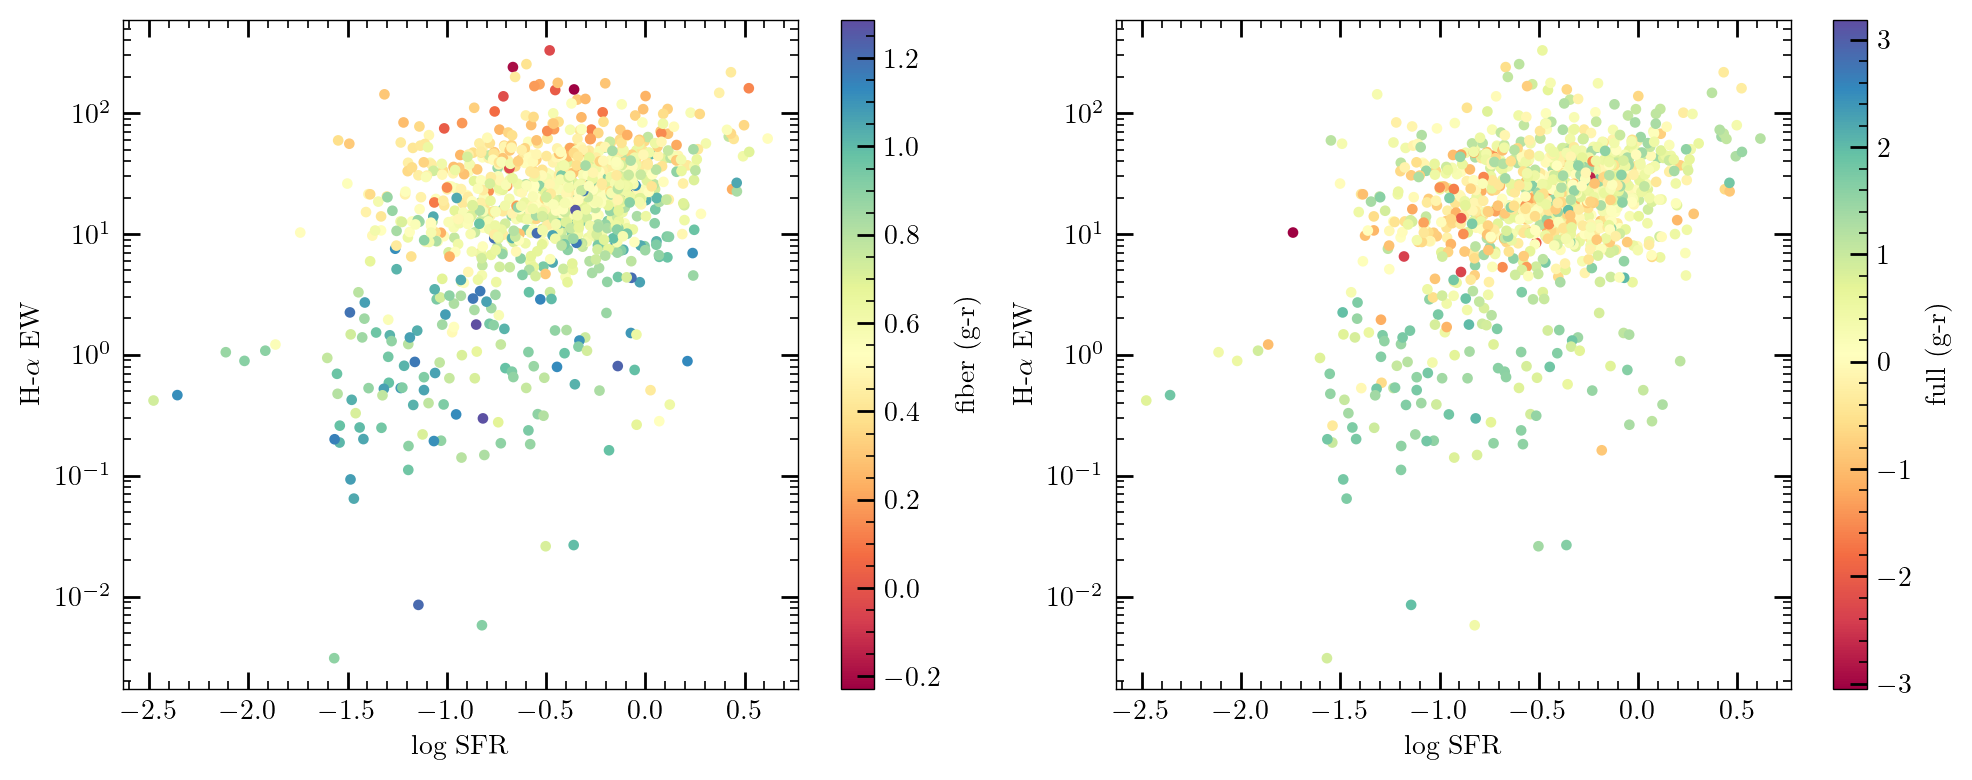

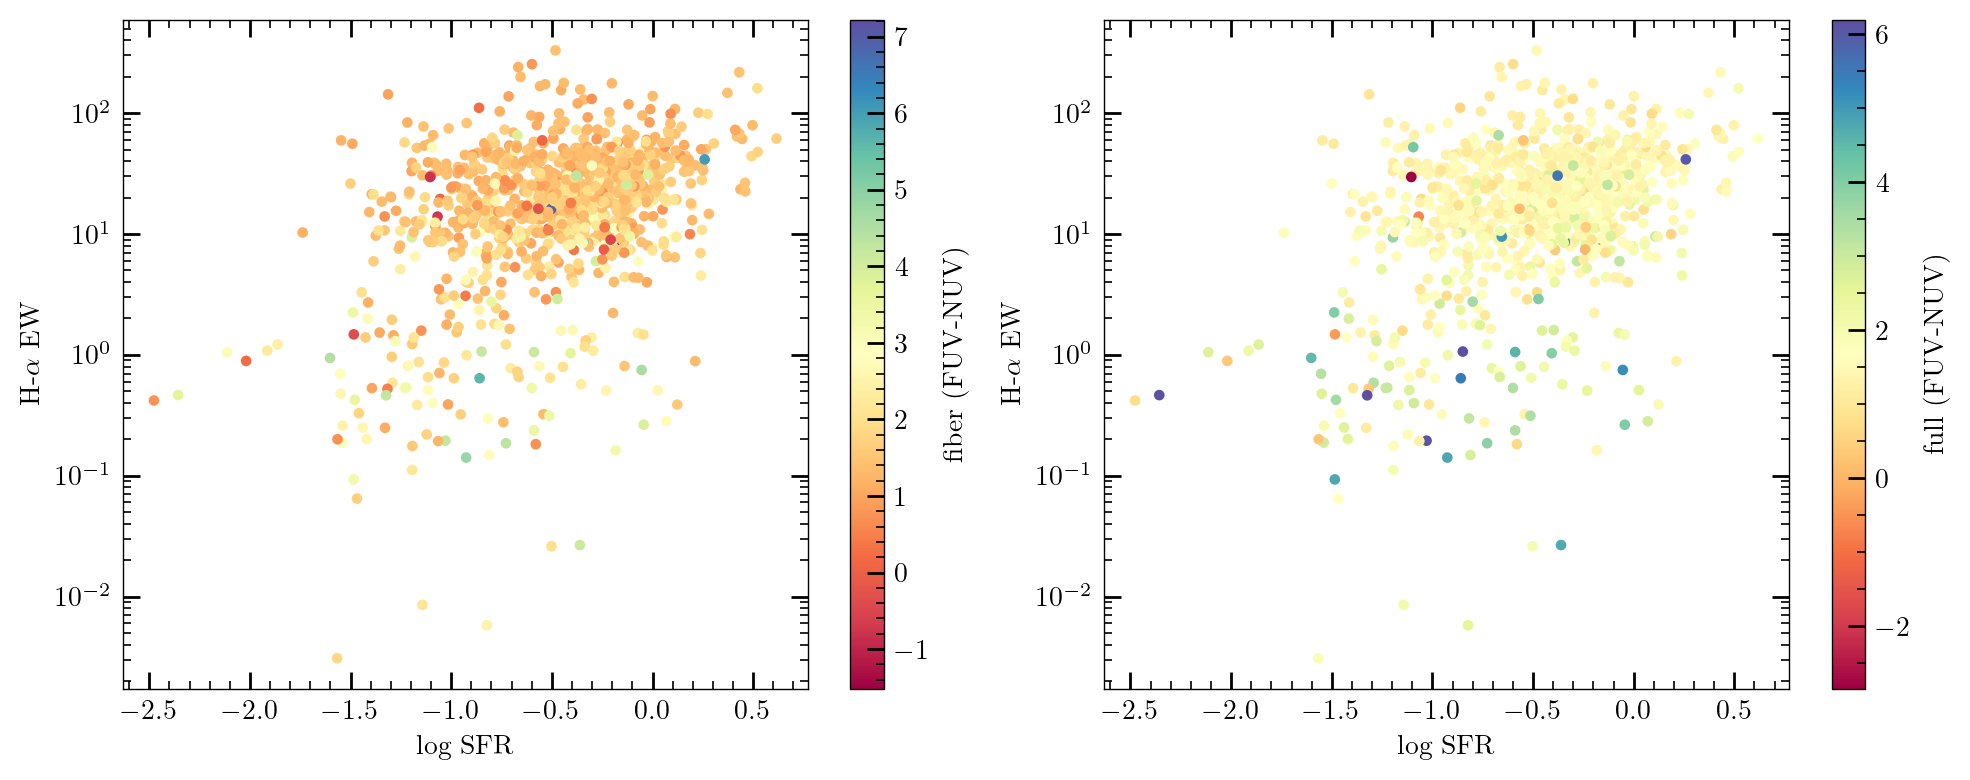

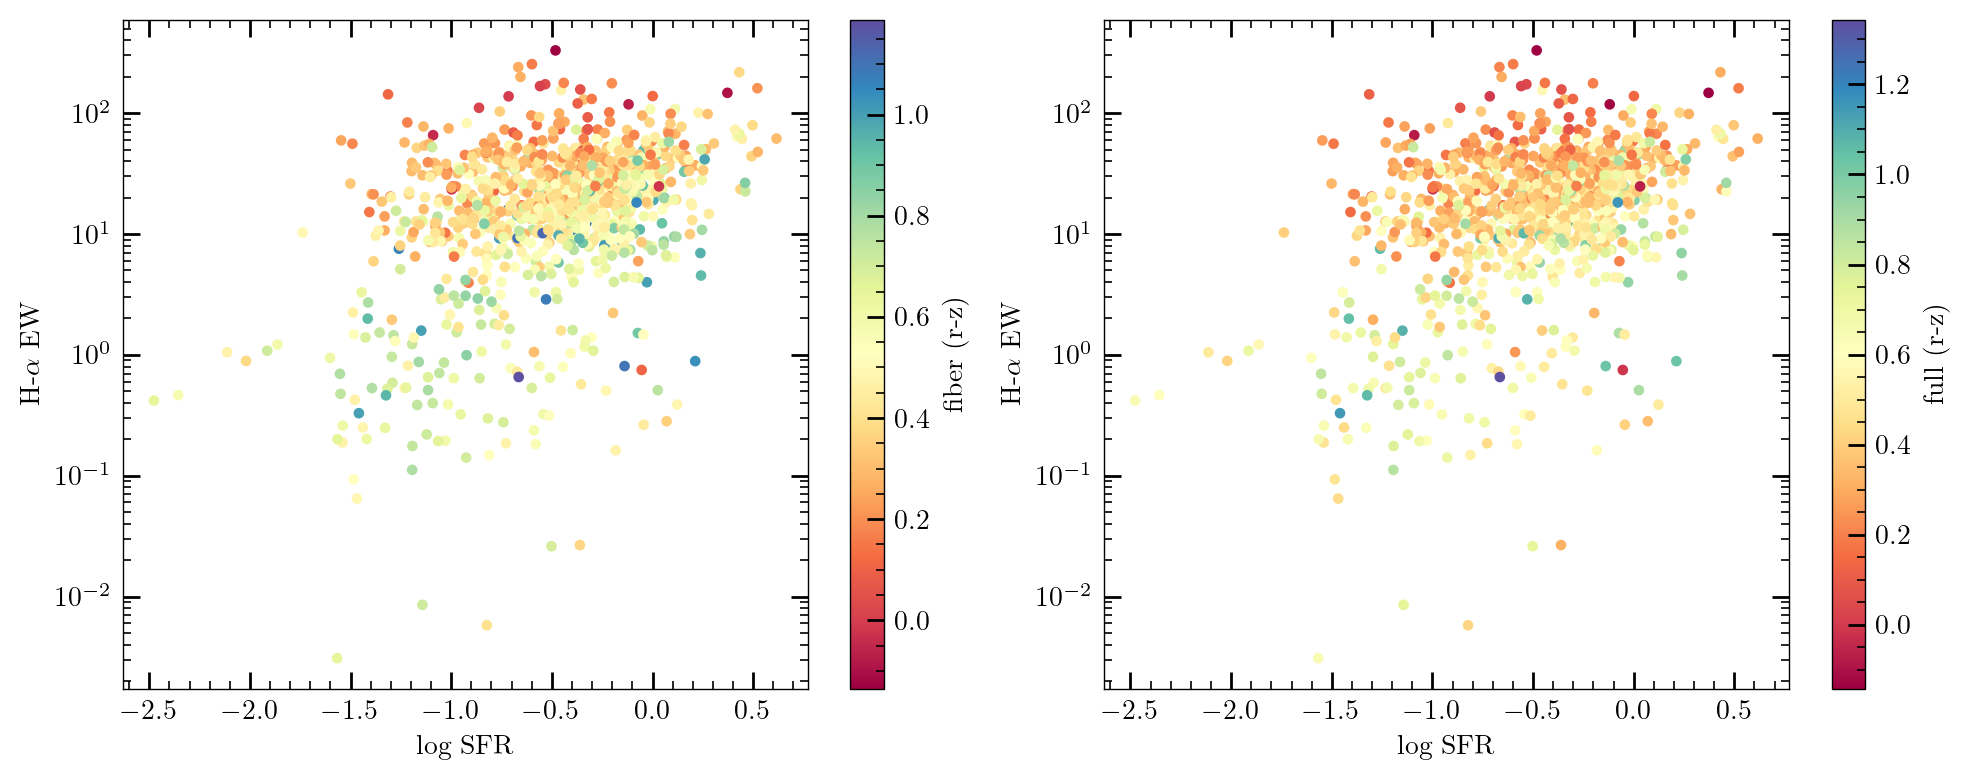

In [304]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['g_r_fiber'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'fiber (g-r)')

img_scat = axes[1].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['g_r_full'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[1])
axes[1].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'full (g-r)')

fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['fuv_nuv_fiber'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'fiber (FUV-NUV)')

img_scat = axes[1].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['fuv_nuv_full'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[1])
axes[1].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'full (FUV-NUV)')

fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['r_z_fiber'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'fiber (r-z)')

img_scat = axes[1].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['r_z_full'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[1])
axes[1].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'full (r-z)')


ValueError: 'c' argument has 2062 elements, which is inconsistent with 'x' and 'y' with size 1031.

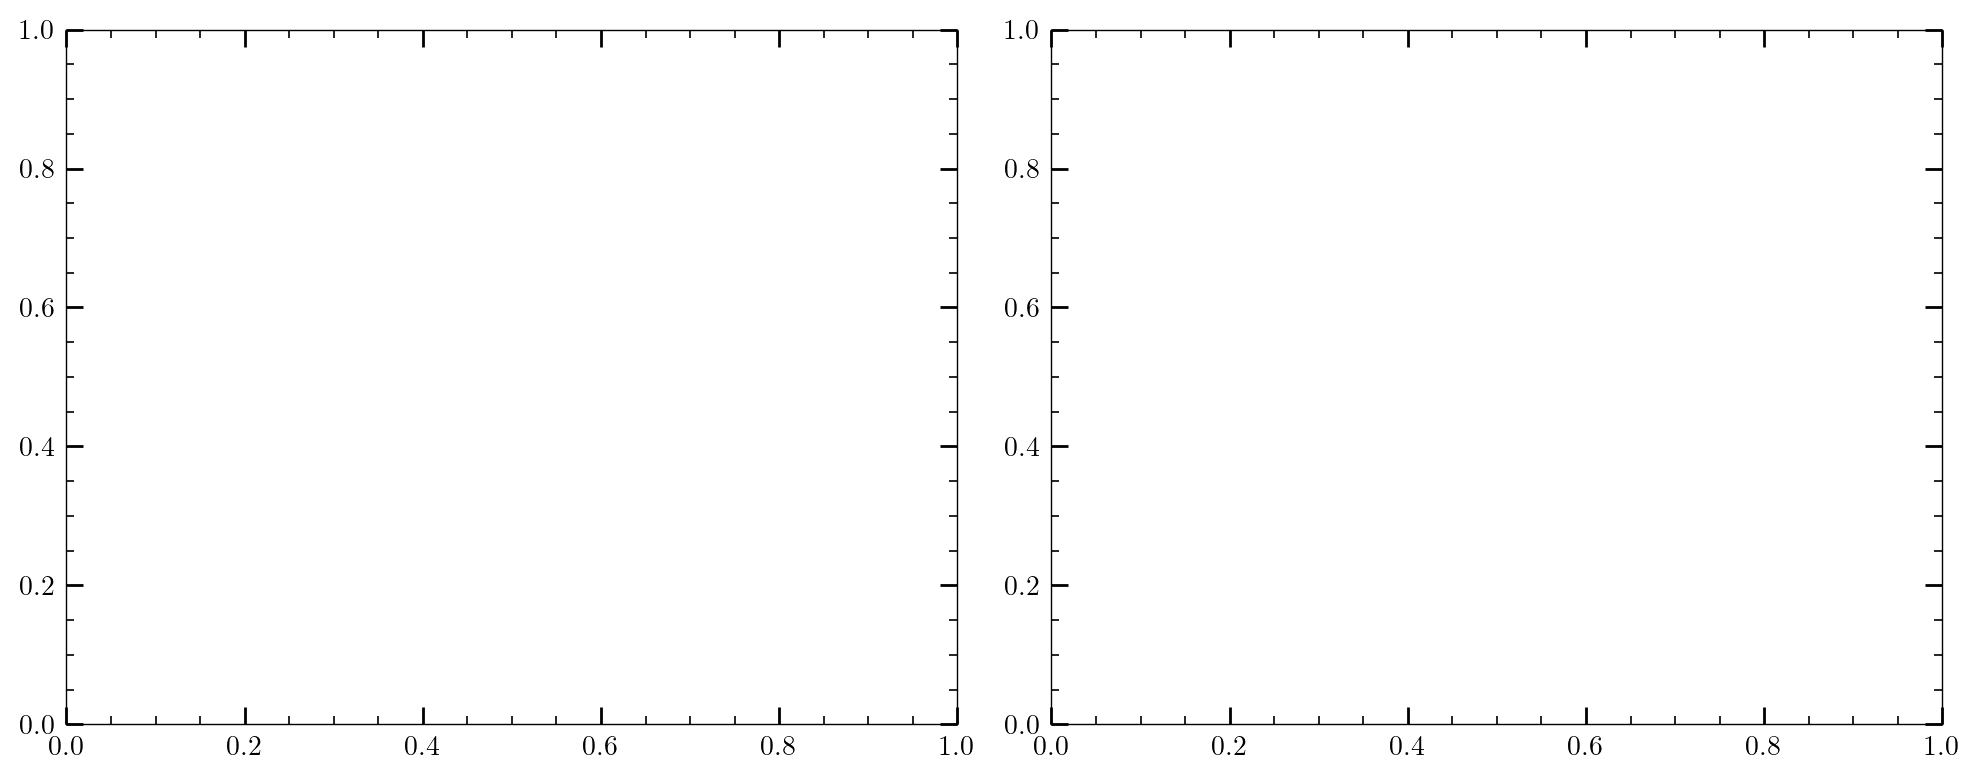

In [305]:
fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['full_r_mag'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'full r')

img_scat = axes[1].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['fiber_r_mag'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[1])
axes[1].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'fiber r')

fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['fiber z'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'fiber z')

img_scat = axes[1].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['full z'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[1])
axes[1].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'full z')

fig, axes = plt.subplots(figsize=(10, 4), dpi=200, ncols=2)

img_scat = axes[0].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['r_z_fiber'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[0])
axes[0].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'fiber (r-z)')

img_scat = axes[1].scatter(cleaned_photodf['SFR'].values, cleaned_photodf['halpha'].values, s=8,
                           c=cleaned_photodf['r_z_full'].values,
                           cmap='Spectral')

cbar = fig.colorbar(img_scat, ax=axes[1])
axes[1].set(xlabel="log SFR", ylabel=r'H-$\alpha$ EW', yscale='log')
cbar.ax.set_ylabel(r'full (r-z)')


In [347]:
cleaned_photodf

,fiber_g_mag,full_g_mag,fiber_r_mag,full_r_mag,fiber_z_mag,full_z_mag,fiber_nuv_mag,full_nuv_mag,fiber_fuv_mag,full_fuv_mag,g_r_fiber,g_r_full,r_z_fiber,r_z_full,fuv_nuv_fiber,fuv_nuv_full,halpha
0,20.630505,20.630505,20.072167,20.072167,19.592112,19.592112,22.856167,22.856167,24.027126,24.027126,0.558338,0.558338,0.480055,0.480055,1.170959,1.170959,21.083307
1,21.055134,20.527209,20.459412,19.929611,20.145202,19.625306,23.416416,22.795154,24.905366,24.351031,0.595722,0.067797,0.314210,0.304305,1.488950,1.555877,38.808548
2,21.417541,20.262839,20.548975,19.422085,19.852283,18.770072,24.532448,23.213055,26.663405,25.484405,0.868565,-0.286136,0.696693,0.652013,2.130957,2.271350,16.460962
3,20.525722,20.525722,19.407658,19.407658,18.345308,18.345308,25.205080,25.205080,26.671650,26.671650,1.118064,1.118064,1.062350,1.062350,1.466570,1.466570,7.550173
4,19.643996,19.643996,18.630520,18.630520,17.745149,17.745149,24.311589,24.311589,26.510112,26.510112,1.013476,1.013476,0.885371,0.885371,2.198523,2.198523,45.684097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,19.494771,20.143997,18.584526,19.196629,18.279364,18.943895,23.595577,24.572537,27.751659,29.166077,0.910244,1.559470,0.305162,0.252734,4.156081,4.593539,1.054364
1119,19.347455,20.024277,18.943415,19.620984,18.964414,19.682285,22.034316,23.032717,23.471794,24.335829,0.404040,1.080862,-0.020999,-0.061301,1.437478,1.303112,24.778261
1120,19.585434,20.303935,18.745119,19.430541,18.364688,19.065300,22.479885,23.428571,24.218554,25.293604,0.840316,1.558817,0.380431,0.365242,1.738669,1.865033,48.699116
1123,19.995803,20.761115,19.570410,20.359438,18.877564,19.612700,22.256783,23.119402,24.142387,25.038750,0.425393,1.190705,0.692846,0.746738,1.885603,1.919349,30.601612


In [348]:
cleaned_halpha_ground_truth = cleaned_photodf['halpha'].values
cleaned_photodf_nohalpha = ncleaned_photodf.drop(columns=['halpha'])

In [350]:
cleaned_photodf_nohalpha = cleaned_photodf_nohalpha.values

In [356]:
cleaned_photodf.shape

(1031, 17)

In [384]:
data_length = len(cleaned_photodf_nohalpha)
train_cap = int(np.floor(0.75*data_length / 50)*50)
print(train_cap)

# define min max scaler
scaler = MinMaxScaler()
# transform data
scaled_input = scaler.fit_transform(cleaned_photodf_nohalpha)
# define min max scaler
scaler2 = MinMaxScaler()
scaled_truth = scaler2.fit_transform(cleaned_halpha_ground_truth.reshape(-1, 1))

train_input = torch.Tensor(scaled_input[:train_cap])
train_ground_truth = torch.Tensor(scaled_truth[:train_cap])
test_input = torch.Tensor(scaled_input[train_cap:])
test_ground_truth = torch.Tensor(scaled_truth[train_cap:])

train_dataset = TensorDataset(train_input, train_ground_truth)
test_dataset = TensorDataset(test_input, test_ground_truth)
batch_size=50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = FeedForwardNet3()

SGD = torch.optim.SGD(model.parameters(), lr=0.001)
SGD.zero_grad()
loss_fn = nn.MSELoss()

train(model, loss_fn, SGD, train_loader, test_loader)

750
number of epochs 2000
epoch 0
loss 0.016714327037334442
 EPOCH 0. Progress: 0.0%. 
 Train accuracy: 0.0. Test accuracy: 0.0
epoch 1
loss 0.015467226505279541
epoch 2
loss 0.014329442754387856
epoch 3
loss 0.013291290029883385
epoch 4
loss 0.012343990616500378
epoch 5
loss 0.01147954910993576
 EPOCH 5. Progress: 0.25%. 
 Train accuracy: 0.184. Test accuracy: 0.196
epoch 6
loss 0.010690866969525814
epoch 7
loss 0.009971478953957558
epoch 8
loss 0.009315483272075653
epoch 9
loss 0.008717426098883152
epoch 10
loss 0.008172380737960339
 EPOCH 10. Progress: 0.5%. 
 Train accuracy: 0.3827. Test accuracy: 0.388
epoch 11
loss 0.007675789762288332
epoch 12
loss 0.007223567459732294
epoch 13
loss 0.006811982486397028
epoch 14
loss 0.006437606643885374
epoch 15
loss 0.006097124889492989
 EPOCH 15. Progress: 0.75%. 
 Train accuracy: 0.5267. Test accuracy: 0.5
epoch 16
loss 0.005787647794932127
epoch 17
loss 0.005506529007107019
epoch 18
loss 0.0052513545379042625
epoch 19
loss 0.005019838921725

 EPOCH 160. Progress: 8.0%. 
 Train accuracy: 0.5987. Test accuracy: 0.56
epoch 161
loss 0.003085991833359003
epoch 162
loss 0.0030845925211906433
epoch 163
loss 0.0030831911135464907
epoch 164
loss 0.003081794362515211
epoch 165
loss 0.00308039179071784
 EPOCH 165. Progress: 8.25%. 
 Train accuracy: 0.5987. Test accuracy: 0.56
epoch 166
loss 0.003078971989452839
epoch 167
loss 0.003077523782849312
epoch 168
loss 0.0030760937370359898
epoch 169
loss 0.003074658801779151
epoch 170
loss 0.003073228057473898
 EPOCH 170. Progress: 8.5%. 
 Train accuracy: 0.5987. Test accuracy: 0.564
epoch 171
loss 0.0030717963818460703
epoch 172
loss 0.003070367034524679
epoch 173
loss 0.003068933729082346
epoch 174
loss 0.0030674731824547052
epoch 175
loss 0.0030659609474241734
 EPOCH 175. Progress: 8.75%. 
 Train accuracy: 0.5973. Test accuracy: 0.564
epoch 176
loss 0.003064448246732354
epoch 177
loss 0.0030629306565970182
epoch 178
loss 0.003061413997784257
epoch 179
loss 0.00305989314801991
epoch 180
l

 EPOCH 320. Progress: 16.0%. 
 Train accuracy: 0.6027. Test accuracy: 0.58
epoch 321
loss 0.0029089725576341152
epoch 322
loss 0.0029083620756864548
epoch 323
loss 0.0029077529907226562
epoch 324
loss 0.002907153684645891
epoch 325
loss 0.002906559035181999
 EPOCH 325. Progress: 16.25%. 
 Train accuracy: 0.6027. Test accuracy: 0.58
epoch 326
loss 0.002905983943492174
epoch 327
loss 0.0029054039623588324
epoch 328
loss 0.00290485005825758
epoch 329
loss 0.0029043019749224186
epoch 330
loss 0.0029037492349743843
 EPOCH 330. Progress: 16.5%. 
 Train accuracy: 0.6013. Test accuracy: 0.58
epoch 331
loss 0.0029032027814537287
epoch 332
loss 0.002902657026425004
epoch 333
loss 0.002902104752138257
epoch 334
loss 0.0029015657491981983
epoch 335
loss 0.0029010216239839792
 EPOCH 335. Progress: 16.75%. 
 Train accuracy: 0.6013. Test accuracy: 0.58
epoch 336
loss 0.002900487743318081
epoch 337
loss 0.0028999540954828262
epoch 338
loss 0.0028994225431233644
epoch 339
loss 0.0028988912235945463
epo

 EPOCH 480. Progress: 24.0%. 
 Train accuracy: 0.6013. Test accuracy: 0.584
epoch 481
loss 0.0028200470842421055
epoch 482
loss 0.0028195646591484547
epoch 483
loss 0.0028190871234983206
epoch 484
loss 0.0028186074923723936
epoch 485
loss 0.002818117383867502
 EPOCH 485. Progress: 24.25%. 
 Train accuracy: 0.6013. Test accuracy: 0.584
epoch 486
loss 0.0028176200576126575
epoch 487
loss 0.0028171194717288017
epoch 488
loss 0.002816644962877035
epoch 489
loss 0.002816170221194625
epoch 490
loss 0.002815691288560629
 EPOCH 490. Progress: 24.5%. 
 Train accuracy: 0.6. Test accuracy: 0.584
epoch 491
loss 0.002815206302329898
epoch 492
loss 0.0028147175908088684
epoch 493
loss 0.002814223524183035
epoch 494
loss 0.0028137238696217537
epoch 495
loss 0.0028132221195846796
 EPOCH 495. Progress: 24.75%. 
 Train accuracy: 0.6. Test accuracy: 0.584
epoch 496
loss 0.002812740160152316
epoch 497
loss 0.0028122644871473312
epoch 498
loss 0.0028117839246988297
epoch 499
loss 0.0028113038279116154
epoc

loss 0.0027295502368360758
epoch 642
loss 0.0027288903947919607
epoch 643
loss 0.0027282312512397766
epoch 644
loss 0.0027275695465505123
epoch 645
loss 0.0027269083075225353
 EPOCH 645. Progress: 32.25%. 
 Train accuracy: 0.6107. Test accuracy: 0.592
epoch 646
loss 0.0027262454386800528
epoch 647
loss 0.0027255809400230646
epoch 648
loss 0.0027249171398580074
epoch 649
loss 0.002724254038184881
epoch 650
loss 0.0027235867455601692
 EPOCH 650. Progress: 32.5%. 
 Train accuracy: 0.6107. Test accuracy: 0.592
epoch 651
loss 0.0027229187544435263
epoch 652
loss 0.0027222493663430214
epoch 653
loss 0.0027215799782425165
epoch 654
loss 0.0027209084946662188
epoch 655
loss 0.0027202367782592773
 EPOCH 655. Progress: 32.75%. 
 Train accuracy: 0.6107. Test accuracy: 0.592
epoch 656
loss 0.0027195618022233248
epoch 657
loss 0.0027188723906874657
epoch 658
loss 0.0027181783225387335
epoch 659
loss 0.0027174788992851973
epoch 660
loss 0.00271677877753973
 EPOCH 660. Progress: 33.0%. 
 Train accura

loss 0.0026005972176790237
epoch 802
loss 0.002599603496491909
epoch 803
loss 0.002598610706627369
epoch 804
loss 0.002597628626972437
epoch 805
loss 0.002596665872260928
 EPOCH 805. Progress: 40.25%. 
 Train accuracy: 0.6267. Test accuracy: 0.616
epoch 806
loss 0.0025957024190574884
epoch 807
loss 0.002594743389636278
epoch 808
loss 0.002593785524368286
epoch 809
loss 0.002592830453068018
epoch 810
loss 0.002591901458799839
 EPOCH 810. Progress: 40.5%. 
 Train accuracy: 0.6267. Test accuracy: 0.616
epoch 811
loss 0.0025909929536283016
epoch 812
loss 0.0025900828186422586
epoch 813
loss 0.0025891743134707212
epoch 814
loss 0.0025882674381136894
epoch 815
loss 0.002587367780506611
 EPOCH 815. Progress: 40.75%. 
 Train accuracy: 0.6267. Test accuracy: 0.616
epoch 816
loss 0.002586466958746314
epoch 817
loss 0.002585571026429534
epoch 818
loss 0.002584675559774041
epoch 819
loss 0.002583779627457261
epoch 820
loss 0.00258290464989841
 EPOCH 820. Progress: 41.0%. 
 Train accuracy: 0.6267. 

loss 0.0024885782040655613
epoch 962
loss 0.002488010562956333
epoch 963
loss 0.0024874494411051273
epoch 964
loss 0.002486888086423278
epoch 965
loss 0.002486324403434992
 EPOCH 965. Progress: 48.25%. 
 Train accuracy: 0.6453. Test accuracy: 0.632
epoch 966
loss 0.002485764678567648
epoch 967
loss 0.0024852068163454533
epoch 968
loss 0.0024846477899700403
epoch 969
loss 0.0024840880651026964
epoch 970
loss 0.002483527874574065
 EPOCH 970. Progress: 48.5%. 
 Train accuracy: 0.6453. Test accuracy: 0.632
epoch 971
loss 0.002482966985553503
epoch 972
loss 0.002482406096532941
epoch 973
loss 0.0024818445090204477
epoch 974
loss 0.002481281291693449
epoch 975
loss 0.0024807220324873924
 EPOCH 975. Progress: 48.75%. 
 Train accuracy: 0.6453. Test accuracy: 0.632
epoch 976
loss 0.002480162074789405
epoch 977
loss 0.002479600952938199
epoch 978
loss 0.0024790388997644186
epoch 979
loss 0.002478483133018017
epoch 980
loss 0.002477949019521475
 EPOCH 980. Progress: 49.0%. 
 Train accuracy: 0.645

loss 0.0024054660461843014
epoch 1123
loss 0.0024049729108810425
epoch 1124
loss 0.00240447954274714
epoch 1125
loss 0.0024039847776293755
 EPOCH 1125. Progress: 56.25%. 
 Train accuracy: 0.6507. Test accuracy: 0.648
epoch 1126
loss 0.0024034895468503237
epoch 1127
loss 0.002402994316071272
epoch 1128
loss 0.0024024993181228638
epoch 1129
loss 0.002402004087343812
epoch 1130
loss 0.0024015072267502546
 EPOCH 1130. Progress: 56.49999999999999%. 
 Train accuracy: 0.6507. Test accuracy: 0.648
epoch 1131
loss 0.002401015954092145
epoch 1132
loss 0.002400523517280817
epoch 1133
loss 0.002400030381977558
epoch 1134
loss 0.002399537479504943
epoch 1135
loss 0.002399044344201684
 EPOCH 1135. Progress: 56.75%. 
 Train accuracy: 0.652. Test accuracy: 0.648
epoch 1136
loss 0.002398550743237138
epoch 1137
loss 0.0023980566766113043
epoch 1138
loss 0.002397562377154827
epoch 1139
loss 0.0023970678448677063
epoch 1140
loss 0.002396572846919298
 EPOCH 1140. Progress: 56.99999999999999%. 
 Train accur

loss 0.002328563015908003
epoch 1280
loss 0.0023280824534595013
 EPOCH 1280. Progress: 64.0%. 
 Train accuracy: 0.6627. Test accuracy: 0.672
epoch 1281
loss 0.0023276018910109997
epoch 1282
loss 0.0023271215613931417
epoch 1283
loss 0.002326640533283353
epoch 1284
loss 0.0023261592723429203
epoch 1285
loss 0.002325677080079913
 EPOCH 1285. Progress: 64.25%. 
 Train accuracy: 0.6627. Test accuracy: 0.672
epoch 1286
loss 0.0023251951206475496
epoch 1287
loss 0.002324712462723255
epoch 1288
loss 0.002324228873476386
epoch 1289
loss 0.002323745284229517
epoch 1290
loss 0.002323262160643935
 EPOCH 1290. Progress: 64.5%. 
 Train accuracy: 0.6627. Test accuracy: 0.672
epoch 1291
loss 0.0023227795027196407
epoch 1292
loss 0.0023222961463034153
epoch 1293
loss 0.002321812557056546
epoch 1294
loss 0.0023213294334709644
epoch 1295
loss 0.002320845378562808
 EPOCH 1295. Progress: 64.75%. 
 Train accuracy: 0.6627. Test accuracy: 0.672
epoch 1296
loss 0.002320364350453019
epoch 1297
loss 0.002319886

loss 0.002254459774121642
epoch 1438
loss 0.002254004590213299
epoch 1439
loss 0.0022535487078130245
epoch 1440
loss 0.0022530921269208193
 EPOCH 1440. Progress: 72.0%. 
 Train accuracy: 0.6667. Test accuracy: 0.684
epoch 1441
loss 0.002252634847536683
epoch 1442
loss 0.0022521798964589834
epoch 1443
loss 0.00225172471255064
epoch 1444
loss 0.0022512690629810095
epoch 1445
loss 0.0022508136462420225
 EPOCH 1445. Progress: 72.25%. 
 Train accuracy: 0.668. Test accuracy: 0.688
epoch 1446
loss 0.0022503570653498173
epoch 1447
loss 0.002249901182949543
epoch 1448
loss 0.002249445067718625
epoch 1449
loss 0.002248988952487707
epoch 1450
loss 0.0022485340014100075
 EPOCH 1450. Progress: 72.5%. 
 Train accuracy: 0.668. Test accuracy: 0.688
epoch 1451
loss 0.0022480774205178022
epoch 1452
loss 0.0022476224694401026
epoch 1453
loss 0.002247167518362403
epoch 1454
loss 0.0022467130329459906
epoch 1455
loss 0.0022462578490376472
 EPOCH 1455. Progress: 72.75%. 
 Train accuracy: 0.668. Test accurac

loss 0.002184242242947221
epoch 1593
loss 0.0021837910171598196
epoch 1594
loss 0.0021833404898643494
epoch 1595
loss 0.002182889496907592
 EPOCH 1595. Progress: 79.75%. 
 Train accuracy: 0.684. Test accuracy: 0.7
epoch 1596
loss 0.0021824392024427652
epoch 1597
loss 0.0021819889079779387
epoch 1598
loss 0.0021815381478518248
epoch 1599
loss 0.0021810876205563545
epoch 1600
loss 0.0021806368604302406
 EPOCH 1600. Progress: 80.0%. 
 Train accuracy: 0.6867. Test accuracy: 0.704
epoch 1601
loss 0.002180185867473483
epoch 1602
loss 0.0021797344088554382
epoch 1603
loss 0.0021792834158986807
epoch 1604
loss 0.002178832422941923
epoch 1605
loss 0.002178381197154522
 EPOCH 1605. Progress: 80.25%. 
 Train accuracy: 0.6867. Test accuracy: 0.704
epoch 1606
loss 0.0021779306698590517
epoch 1607
loss 0.0021774827037006617
epoch 1608
loss 0.002177033806219697
epoch 1609
loss 0.0021765856072306633
epoch 1610
loss 0.0021761388052254915
 EPOCH 1610. Progress: 80.5%. 
 Train accuracy: 0.688. Test accur

loss 0.0021138591691851616
epoch 1750
loss 0.0021133958362042904
 EPOCH 1750. Progress: 87.5%. 
 Train accuracy: 0.6933. Test accuracy: 0.72
epoch 1751
loss 0.00211293320171535
epoch 1752
loss 0.002112471731379628
epoch 1753
loss 0.002112009096890688
epoch 1754
loss 0.002111547626554966
epoch 1755
loss 0.0021110877860337496
 EPOCH 1755. Progress: 87.75%. 
 Train accuracy: 0.6947. Test accuracy: 0.72
epoch 1756
loss 0.0021106272470206022
epoch 1757
loss 0.002110167173668742
epoch 1758
loss 0.0021097068674862385
epoch 1759
loss 0.0021092465613037348
epoch 1760
loss 0.002108786953613162
 EPOCH 1760. Progress: 88.0%. 
 Train accuracy: 0.6947. Test accuracy: 0.72
epoch 1761
loss 0.0021083278115838766
epoch 1762
loss 0.0021078672725707293
epoch 1763
loss 0.0021074076648801565
epoch 1764
loss 0.0021069536451250315
epoch 1765
loss 0.002106501255184412
 EPOCH 1765. Progress: 88.25%. 
 Train accuracy: 0.696. Test accuracy: 0.72
epoch 1766
loss 0.0021060488652437925
epoch 1767
loss 0.002105596940

loss 0.002039161743596196
epoch 1910
loss 0.002038679551333189
 EPOCH 1910. Progress: 95.5%. 
 Train accuracy: 0.708. Test accuracy: 0.728
epoch 1911
loss 0.0020381968934088945
epoch 1912
loss 0.002037713536992669
epoch 1913
loss 0.002037230646237731
epoch 1914
loss 0.0020367472898215055
epoch 1915
loss 0.002036262536421418
 EPOCH 1915. Progress: 95.75%. 
 Train accuracy: 0.708. Test accuracy: 0.728
epoch 1916
loss 0.002035777783021331
epoch 1917
loss 0.002035293495282531
epoch 1918
loss 0.002034809673205018
epoch 1919
loss 0.0020343256182968616
epoch 1920
loss 0.0020338413305580616
 EPOCH 1920. Progress: 96.0%. 
 Train accuracy: 0.708. Test accuracy: 0.732
epoch 1921
loss 0.002033357275649905
epoch 1922
loss 0.002032872289419174
epoch 1923
loss 0.002032388234511018
epoch 1924
loss 0.0020319041796028614
epoch 1925
loss 0.0020314196590334177
 EPOCH 1925. Progress: 96.25%. 
 Train accuracy: 0.7093. Test accuracy: 0.732
epoch 1926
loss 0.0020309353712946177
epoch 1927
loss 0.0020304515492

In [385]:
output_almanach = np.array([])
check_collection = np.array([])
with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
    for data, targets in test_loader:
        #print(data)
        print(data.shape)
        try:
            model_input = torch.reshape(data, [batch_size, 16])
        except RuntimeError as e:
            continue
        output = model(model_input)
        print(output.detach().numpy())
        output_almanach = np.hstack([output_almanach, output.detach().numpy().flatten()])
        check_collection = np.hstack([check_collection, targets.detach().numpy().flatten()])

torch.Size([50, 16])
[[0.03685988]
 [0.08007205]
 [0.05460587]
 [0.0624185 ]
 [0.08161066]
 [0.09548365]
 [0.04221717]
 [0.0613149 ]
 [0.07991832]
 [0.0910559 ]
 [0.08982302]
 [0.08126904]
 [0.0782385 ]
 [0.08438662]
 [0.05760179]
 [0.08240364]
 [0.1064861 ]
 [0.04942047]
 [0.09158757]
 [0.04602179]
 [0.07031775]
 [0.07533132]
 [0.08244546]
 [0.0586712 ]
 [0.04725061]
 [0.08581953]
 [0.0541141 ]
 [0.08078337]
 [0.05390043]
 [0.0874415 ]
 [0.046804  ]
 [0.05301988]
 [0.05582121]
 [0.08448715]
 [0.07362544]
 [0.07726632]
 [0.03584193]
 [0.06322178]
 [0.08820821]
 [0.0811246 ]
 [0.04949534]
 [0.0767588 ]
 [0.04276869]
 [0.07475505]
 [0.07776473]
 [0.06640483]
 [0.08924489]
 [0.07359859]
 [0.05822601]
 [0.05037877]]
torch.Size([50, 16])
[[0.08697809]
 [0.08568332]
 [0.07848629]
 [0.09457734]
 [0.0615559 ]
 [0.09021502]
 [0.08476099]
 [0.0947872 ]
 [0.08390099]
 [0.08132739]
 [0.08613207]
 [0.06954956]
 [0.07769468]
 [0.08199169]
 [0.04437798]
 [0.08561982]
 [0.0927803 ]
 [0.09716609]
 [0.0

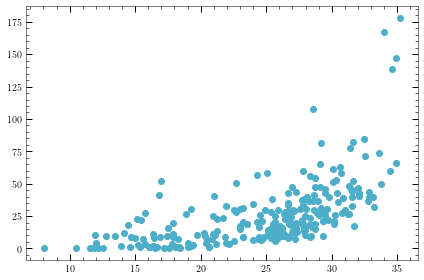

In [386]:
plt.scatter( scaler2.inverse_transform(output_almanach.reshape(-1, 1)),
            scaler2.inverse_transform(check_collection.reshape(-1,1)))

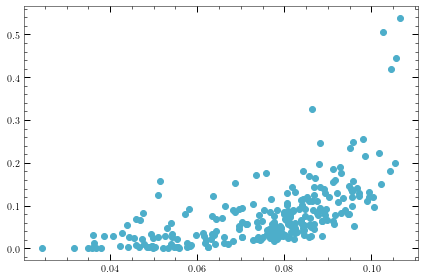

In [387]:
plt.scatter( output_almanach,
            check_collection)

In [367]:
scaled

array([[0.68272537, 0.73930509, 0.70677885, ..., 0.41876867, 0.30761369,
        0.44453073],
       [0.77514953, 0.72315214, 0.78359838, ..., 0.30040632, 0.34402526,
        0.48711146],
       [0.85403026, 0.68181102, 0.80136536, ..., 0.53457766, 0.41753817,
        0.56625912],
       ...,
       [0.4552571 , 0.68823744, 0.44352695, ..., 0.34144527, 0.37261928,
        0.52131113],
       [0.54457719, 0.75972933, 0.60724326, ..., 0.59837211, 0.38944402,
        0.52731973],
       [0.48540005, 0.52258751, 0.53936528, ..., 0.21524404, 0.3721758 ,
        0.50439928]])